# Libraries


In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from datetime import date
d2 = date.today() - timedelta(days=200)
d2 = d2.strftime("%Y-%m-%d")
plt.rcParams['figure.figsize'] = [20, 10]


In [2]:
def lines():
    for y, color, linestyle in [(0, 'black', '-'),
                                (1.0, 'green', '-'),
                                (2.5, 'green', '--'),
                                (3, 'magenta', '--'),
                                (-1.0, 'red', '--'),
                                (-2.5, 'red', '--'),
                                (-3, 'magenta', '--')]:
        plt.axhline(y=y, color=color, linestyle=linestyle)

# Importing the csv files with nifty200 stocks.


In [3]:
tickers=pd.read_csv('ind_nifty100list (1).csv')
tickers['Symbol']=tickers['Symbol']+str('.NS')
download=(tickers['Symbol'].to_list())

# Getting the dataset ready




In [4]:
##Close values from yfinance

df=yf.download(tickers=download,start=d2)['Close']

[*********************100%***********************]  98 of 98 completed


In [17]:
##Checking for any nan values.
(df.isna().sum())

ACC.NS           0
ADANIENT.NS      0
ADANIGREEN.NS    0
ADANIPORTS.NS    0
ADANITRANS.NS    0
                ..
ULTRACEMCO.NS    0
UPL.NS           0
VEDL.NS          0
WIPRO.NS         0
ZOMATO.NS        0
Length: 98, dtype: int64

In [13]:
##filling any NaN values.

df.fillna(method='bfill',inplace=True)


In [25]:
##Creating a second DataFrame of pct_change() for correlation matrix
df2=df.pct_change()
df2=df2.dropna()

##Correlation 

corr=df2.corr()


<AxesSubplot: >

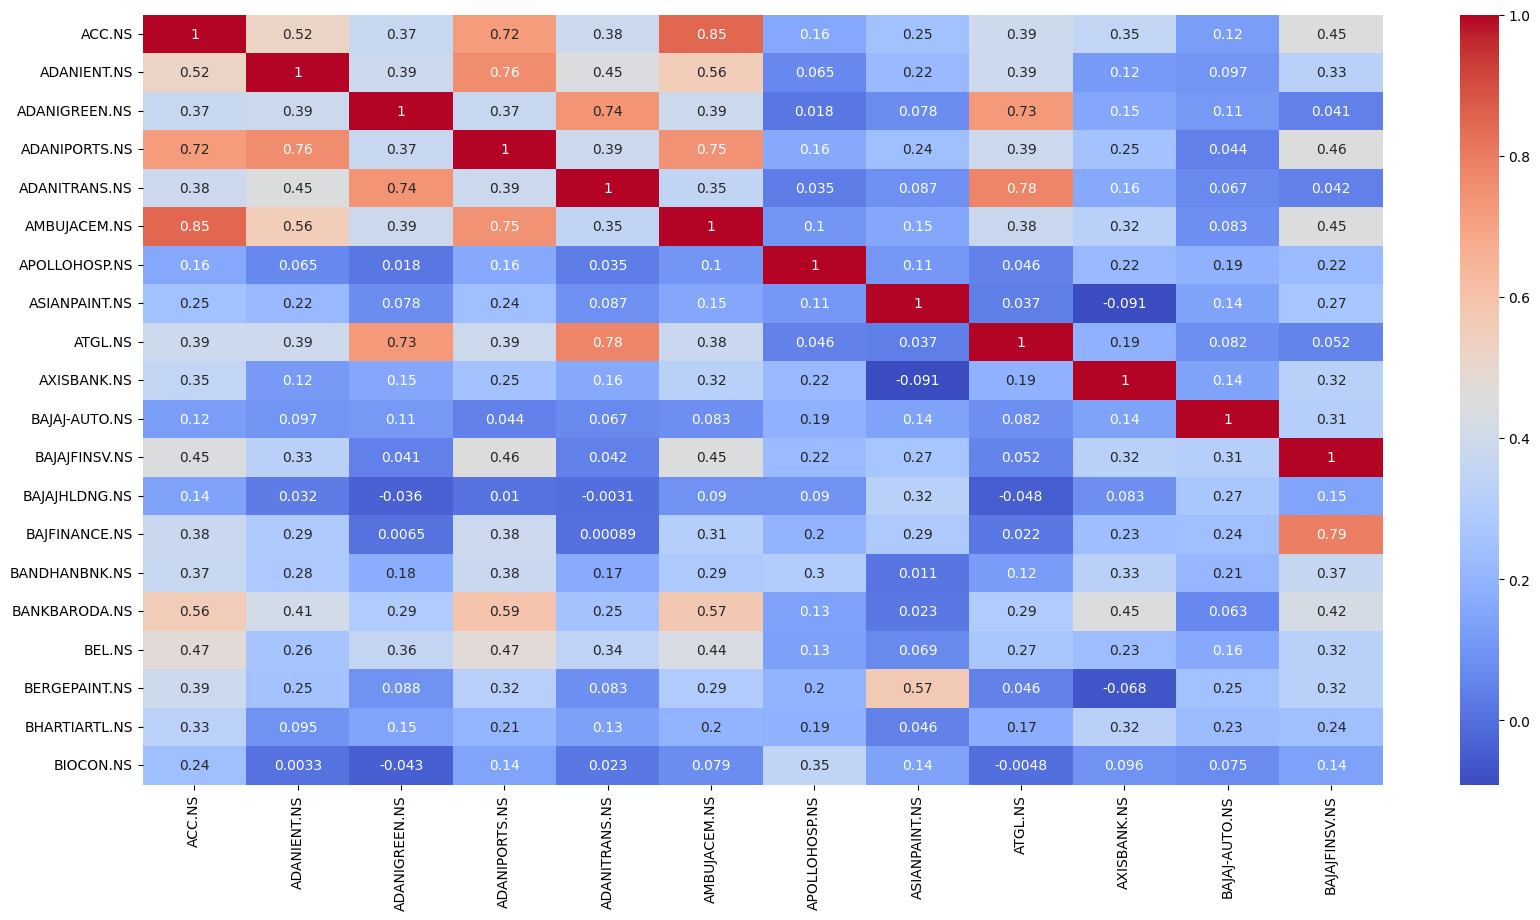

In [30]:
##Visualizing the correlation matrix

sns.heatmap(corr.iloc[:20, :12]
, annot=True, cmap='coolwarm')

In [31]:
#Convert the matrix to a dataframe

corr_long = corr.stack().reset_index()
corr_long.columns = ['stock1', 'stock2', 'correlation']

In [33]:
##The final dataframe without repetitions
Finale=corr_long.loc[corr_long['correlation']!=1]
Finale=Finale.sort_values(by='correlation', ascending=False)
Finale=Finale.drop_duplicates('correlation')

In [34]:
##Selecting stocks with atleast 0.5 corrcoef value

Finale=Finale.loc[Finale['correlation']>0.5]

In [36]:
Finale

,stock1,stock2,correlation
3962,HDFC.NS,HDFCBANK.NS,0.939900
5,ACC.NS,AMBUJACEM.NS,0.846859
7855,SBIN.NS,BANKBARODA.NS,0.798712
1091,BAJAJFINSV.NS,BAJFINANCE.NS,0.793783
8669,TATASTEEL.NS,HINDALCO.NS,0.790378
...,...,...,...
4175,HDFCBANK.NS,LT.NS,0.504150
7745,SBILIFE.NS,ADANIPORTS.NS,0.502181
4033,HDFCAMC.NS,BANKBARODA.NS,0.502048
6555,MUTHOOTFIN.NS,TATAPOWER.NS,0.501642


# Scatter Plot to visualize strongly and weakly correlated assets


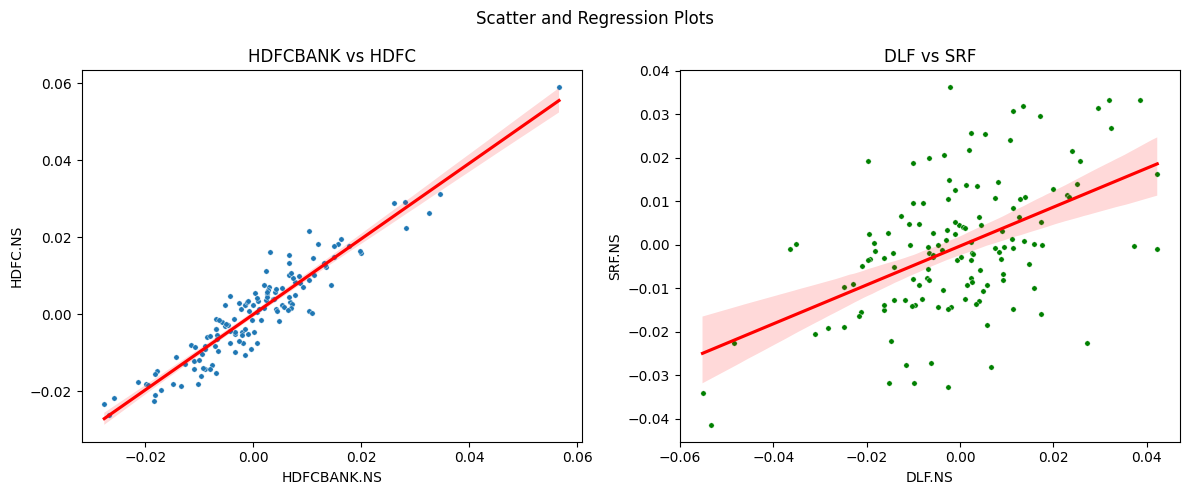

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# First subplot
sns.scatterplot(x=df2['HDFCBANK.NS'], y=df2['HDFC.NS'], data=df, ax=ax1,s=15)
sns.regplot(x=df2['HDFCBANK.NS'], y=df2['HDFC.NS'], data=df, color='red', scatter=False, ax=ax1)
ax1.set_xlabel('HDFCBANK.NS')
ax1.set_ylabel('HDFC.NS')
ax1.set_title('HDFCBANK vs HDFC')

# Second subplot
sns.scatterplot(x=df2['DLF.NS'], y=df2['SRF.NS'], data=df, ax=ax2,s=15,color='green')
sns.regplot(x=df2['DLF.NS'], y=df2['SRF.NS'], data=df, color='red', scatter=False, ax=ax2)
ax2.set_xlabel('DLF.NS')
ax2.set_ylabel('SRF.NS')
ax2.set_title('DLF vs SRF')

fig.suptitle('Scatter and Regression Plots')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

# Performing the calculation

In [53]:
##Take the pairs and convert them to numpy arrays
stock1=np.array(df[Finale['stock1'].iloc[60]])
stock2=np.array(df[Finale['stock2'].iloc[60]])



##Correlation

correlation=(df2[Finale['stock1'].iloc[0]]).corr(df2[Finale['stock2'].iloc[0]])
##Perform Linear Regression 
reg=np.polyfit(stock1,stock2, deg=1)
reg
trend=np.polyval(reg,stock1)

##Calculate residuals for ADF test

ratio=stock1/stock2

ratio=stats.zscore(ratio)

##Perform the ADF test

from statsmodels.tsa.stattools import adfuller

series = ratio
X = series
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if(result[1]<0.05):
    print("ADF test passed")
else:
    print("ADF test failed")

    
correlation


ADF Statistic: -1.399338
p-value: 0.582593
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579
ADF test failed


0.9399003407563619

# Defining the test in a function

In [61]:
def PairTrade(i):
    stock1=np.array(df[Finale['stock1'].iloc[i]])
    stock2=np.array(df[Finale['stock2'].iloc[i]])

    correlation=(df2[Finale['stock1'].iloc[i]]).corr(df2[Finale['stock2'].iloc[i]])
    
    #Industry names
    industry1=tickers.loc[tickers['Symbol'] ==Finale['stock1'].iloc[i]].iloc[0]['Industry']
    industry2=tickers.loc[tickers['Symbol'] ==Finale['stock2'].iloc[i]].iloc[0]['Industry']

    
    
    
    ##Calculate residuals for ADF test

    residuals=stock1/stock2
    
    currentRatio=stock1[-1]/stock2[-1]

    if(residuals[-1]>np.mean(residuals)):
        
        TargetRatio=np.mean(stock1/stock2)+np.std(stock1/stock2)
        SLRatio=np.mean(stock1/stock2)+3*np.std(stock1/stock2)
        
    if(residuals[-1]<np.mean(residuals)):
        TargetRatio=np.mean(stock1/stock2)-np.std(stock1/stock2)
        SLRatio=np.mean(stock1/stock2)-3*np.std(stock1/stock2)
                

    
    #convert residuals to their zscores
    residuals=stats.zscore(residuals)

    ##Perform the ADF test

    from statsmodels.tsa.stattools import adfuller

    series = residuals
    X = series
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if(result[1]<0.05):
        print("ADF test passed")
        print("Target:",abs((TargetRatio-currentRatio)/currentRatio))
    else:
        print("ADF test failed")
        
    
    return(Finale['stock1'].iloc[i],Finale['stock2'].iloc[i],result[1],residuals[-1],correlation,industry1,industry2,currentRatio,SLRatio,TargetRatio)

In [62]:
##Now you can run this function for the entire dataframe at once.
start = time.time()

Trades=[]
for i in range(len(Finale)):
    Trades.append(PairTrade(i))
end = time.time()
end-start  

ADF Statistic: -2.270248
p-value: 0.181743
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -2.320316
p-value: 0.165499
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -0.962479
p-value: 0.766702
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -1.171603
p-value: 0.685690
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -2.173817
p-value: 0.215885
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -1.026176
p-value: 0.743598
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -1.383973
p-value: 0.589935
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -0.826835
p-value: 0.811112
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
ADF test failed
ADF Statistic: -2.790648
p-value: 0.059622
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578

0.6240971088409424

In [63]:
DailyTrades=pd.DataFrame(Trades,columns=['stock1','stock2','pvalue','zscore','correlation','Sector1','Sector2','Current Ratio','SL Ratio','Target Ratio'])
##Here we only select the pairs that have a pvalue of 0.05 or lesser 
DailyTrades=DailyTrades.loc[DailyTrades['pvalue']<=0.05]


In [77]:
DailyTrades

,stock1,stock2,pvalue,zscore,correlation,Sector1,Sector2,Current Ratio,SL Ratio,Target Ratio
32,HINDALCO.NS,VEDL.NS,0.002837,-0.325358,0.591370,Metals & Mining,Metals & Mining,1.429698,1.280474,1.392058
37,VEDL.NS,TATASTEEL.NS,0.005683,-0.838315,0.578137,Metals & Mining,Metals & Mining,2.666178,2.431807,2.648648
40,GRASIM.NS,DLF.NS,0.029755,1.524276,0.573006,Construction Materials,Realty,4.675889,4.851283,4.613577
52,VEDL.NS,JSWSTEEL.NS,0.001248,-0.756030,0.537799,Metals & Mining,Metals & Mining,0.413979,0.379334,0.410212
53,SHREECEM.NS,ULTRACEMCO.NS,0.011836,0.190319,0.537370,Construction Materials,Construction Materials,3.433955,3.701636,3.511094
74,KOTAKBANK.NS,ICICIBANK.NS,0.005024,-1.331076,0.508864,Financial Services,Financial Services,2.009190,1.942242,2.022472


In [81]:
def PlotTrade(i):
    stock1=np.array(df[DailyTrades['stock1'].iloc[i]])
    stock2=np.array(df[DailyTrades['stock2'].iloc[i]])

    #Calculate residuals for ADF test

    ratio=stock1/stock2

    #convert residuals to their zscores
    ratio=stats.zscore(ratio)
    
    ##Perform the ADF test

    from statsmodels.tsa.stattools import adfuller

    series = ratio
    X = series
    result = adfuller(X)
    
    plt.plot(ratio)
    lines()

In [87]:
##Finally we look for trades
#To qualify as a trade there should be a pair that has a pvalue<0.05 and the zscore be greater than 2.5 or less than -2.5

##The stocks in this dataframe will qualify to open positions the next day.
TheFinalTrades=DailyTrades.loc[(abs(DailyTrades['zscore'])>2.5)&(abs(DailyTrades['pvalue'])<0.05)]

# Visualize the stationary series

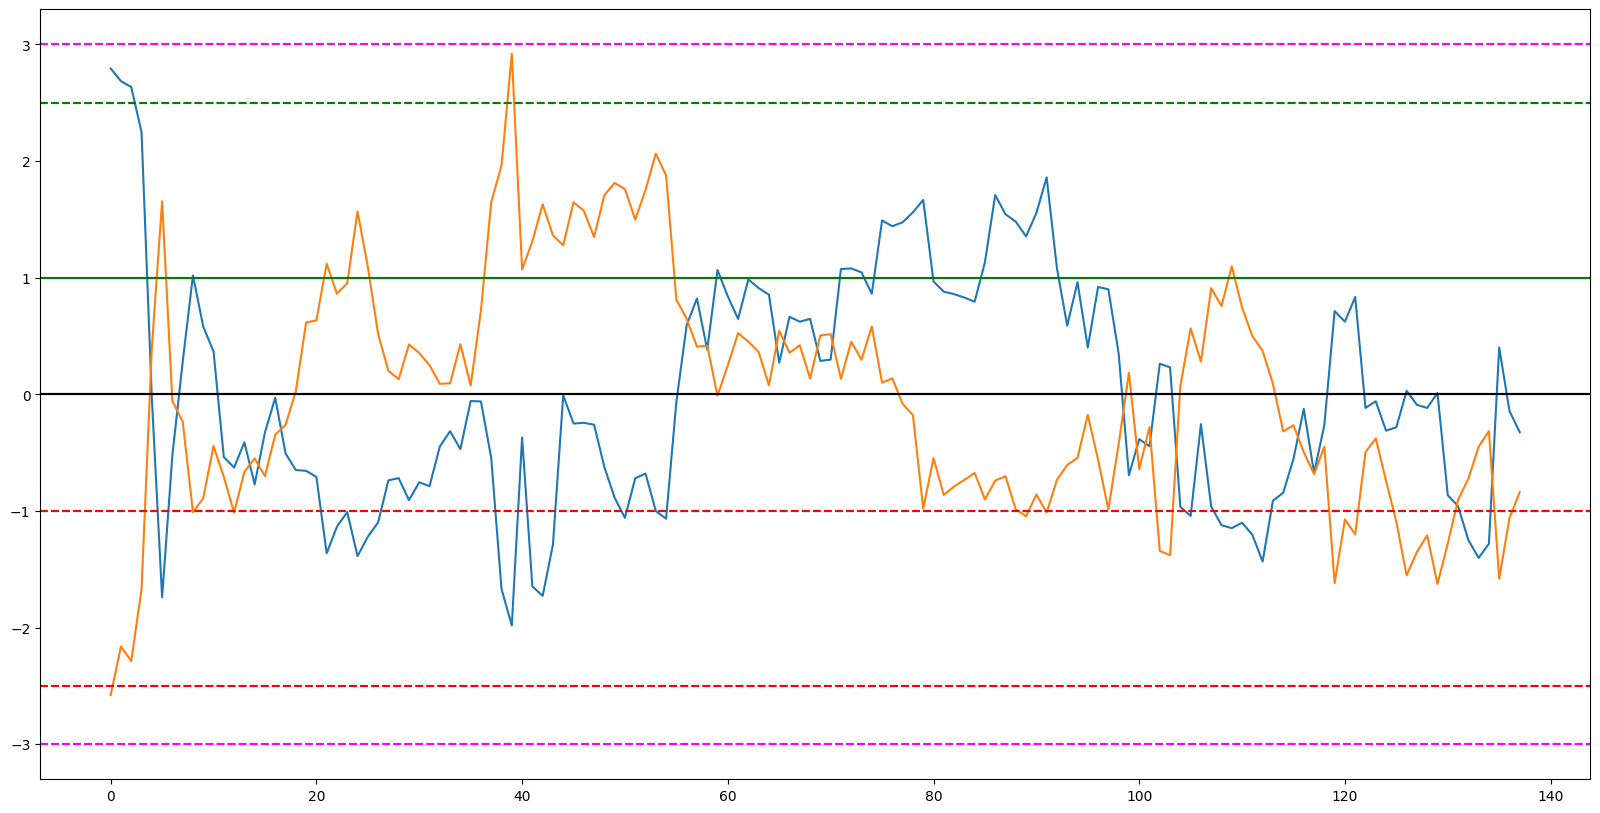

In [86]:
for i in range(2):
    PlotTrade(i)

In [92]:
if(len(TheFinalTrades)==0):
    print("No Trades for next trading session")
else:
    print(TheFinalTrades)

No Trades for next trading session
